<a href="https://colab.research.google.com/github/MercyMoparthy/project-nlp-challenge/blob/main/NLPModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 4: Baseline Model with Stemming + Logistic Regression

Set up a basic pipeline using manual text preprocessing and Logistic Regression.

## 🔧 Steps:
1. Import Librairies and load data (Assign columns name)

2. Preprocessing:

    - Remove punctuation and digits

    - Tokenize

    - Remove stopwords

    - Stemming (using NLTK’s PorterStemmer)

    - Join tokens back into a string

3. Vectorization:

    - TF-IDF Vectorization + HyperParameters

4. Model:

    - Logistic Regression

5. Evaluation:

    - Accuracy, confusion matrix, classification report

6. Prediction for Testing Data

##  ✅ Purpose:
Establish a working pipeline and baseline score (~70-80% accuracy is expected here).

## 1. Import Librairies and load data

In [28]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv("data/training_data_lowercase.csv", sep="\t", header=None, names=["label", "title"])
data.reset_index(drop=True, inplace=True)  # optional

data.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


## 2. Preprocessing:
* StopWords
* Tokenization
* Stemmer and Lemmatizer
* Removing Special Characters and Digits

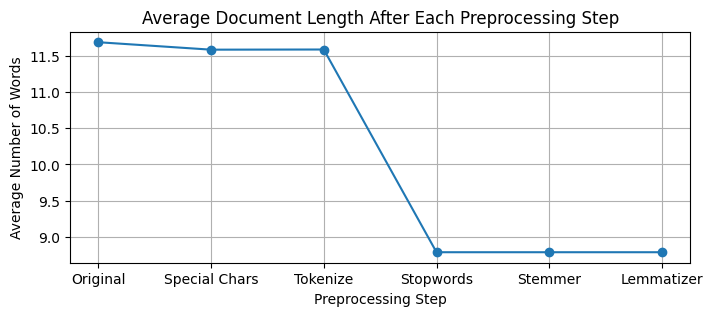

In [30]:
# Step 1: For plotting (intermediate results)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
special_removed = data['title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
tokenized = special_removed.apply(word_tokenize)
no_stopwords = tokenized.apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])
stemmed = no_stopwords.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

steps = [
    "Original",
    "Special Chars",
    "Tokenize",
    "Stopwords",
    "Stemmer",
    "Lemmatizer"
]
avg_lengths = [
    data['title'].apply(lambda x: len(x.split())).mean(),
    special_removed.apply(lambda x: len(x.split())).mean(),
    tokenized.apply(len).mean(),
    no_stopwords.apply(len).mean(),
    stemmed.apply(len).mean(),
    lemmatized.apply(len).mean()
]

plt.figure(figsize=(8,3))
plt.plot(steps, avg_lengths, marker='o')
plt.title("Average Document Length After Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Average Number of Words")
plt.grid(True)
plt.show()

In [31]:
import string
# Step 2: For final clean data (single function)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove special characters
    text = re.sub(r'\b\w\b', '', text) # remove single characters
    tokens = word_tokenize(text) # tokenization
    tokens = [w for w in tokens if w.lower() not in stop_words] # remove stop words
    tokens = [char for char in tokens if char not in string.punctuation and not char.isdigit()] # remove punctuations and digits
    tokens = [stemmer.stem(w) for w in tokens] # stemmerizing
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # lemmatizing
    return " ".join(tokens)

data["clean_title"] = data["title"].apply(preprocess_text)

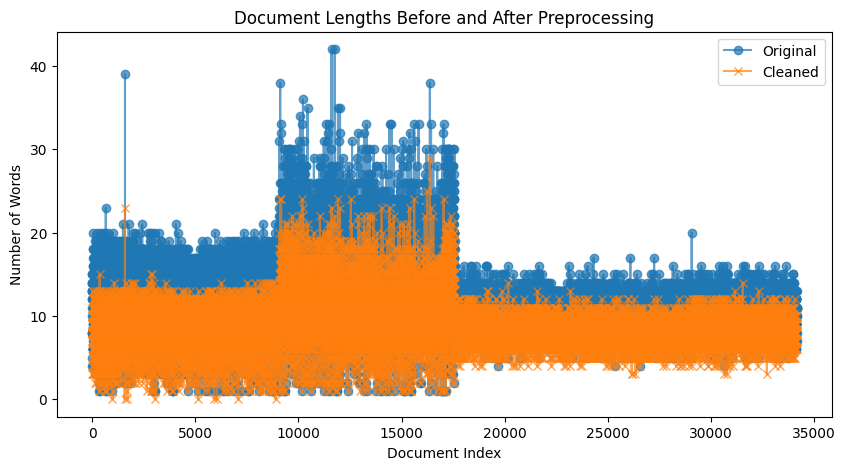

In [32]:
# Calculate document lengths before and after preprocessing
orig_lengths = data['title'].apply(lambda x: len(x.split()))
clean_lengths = data['clean_title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.plot(orig_lengths.values, label='Original', marker='o', alpha=0.7)
plt.plot(clean_lengths.values, label='Cleaned', marker='x', alpha=0.7)
plt.title('Document Lengths Before and After Preprocessing')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

Class Distribution

C:\Users\Mercy\AppData\Local\Temp\ipykernel_30048\3775043527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette=bar_colors)


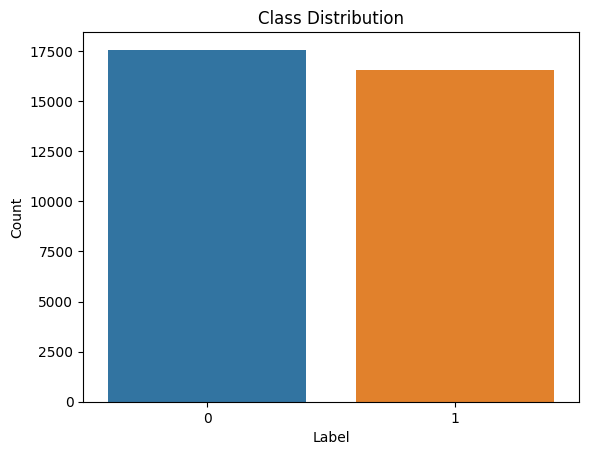

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
bar_colors = ['#1f77b4', '#ff7f0e']
sns.countplot(x='label', data=data, palette=bar_colors)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## 3. Train Split and Vectorization

Create a TF-IDF Representation

In [34]:
tfidf_vectorizer = TfidfVectorizer(
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.80,
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(data['title'])

# x_tfidf is a sparse matrix of TF-IDF features
print(X_train_tfidf.shape) 
print("TF-IDF Representation:\n", X_train_tfidf.toarray())

(34152, 10000)
TF-IDF Representation:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TF-IDF Vector Projection

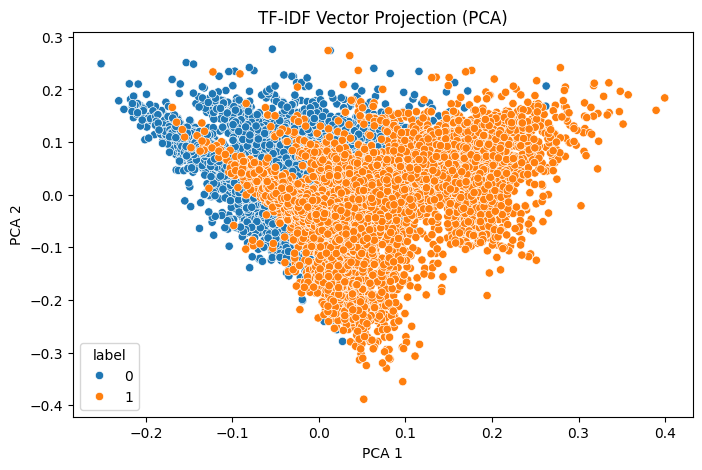

In [35]:
import seaborn as sns
from sklearn.decomposition import PCA

# Initialize PCA for 2 components
pca = PCA(n_components=2)

# Use the TF-IDF matrix for PCA
X_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['label'], palette='tab10')
plt.title('TF-IDF Vector Projection (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## 4. Logistic Regression Model

In [36]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Prepare features and labels
X = X_train_tfidf
y = data['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

## 5. Evaluation

In [37]:
# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9471526862831211
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3529
           1       0.94      0.95      0.95      3302

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831



HeatMap

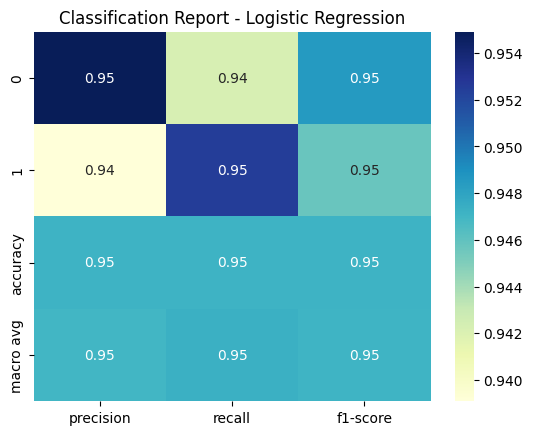

In [38]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report - Logistic Regression')
plt.show()

## 6. Confusion Matrix

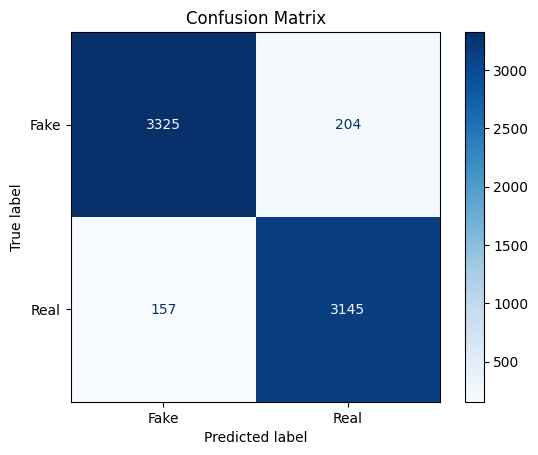

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the actual labels from new_data
true_labels = data['label']
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()